# BarrelNet Inference Notebook
This Notebook will run the code to run an inference pipeline for the trained Model, given a single Barrel point cloud sample as input. 

In [1]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from tqdm import tqdm
import os
import torch
import torch.optim as optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import uuid
import roma
from data import generate_cylinder_pts, prepare_point_cloud, normalize_pc, CylinderData
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from pointnet_utils import PointNetEncoder, feature_transform_reguliarzer
from barrelnet import BarrelNet

In [6]:
## Load Model 
model_path = 'weights/pointnet.pth'

pointnet = BarrelNet(k=4, normal_channel=False).cuda()
pointnet.load_state_dict(torch.load(model_path))
pointnet.eval()

## TODO Write code here to prepare a random input point cloud for inference. 
pts = torch.rand(1100).cuda() ## Replace this with dust3r point cloud extracted for the barrel
pts, scale = normalize_pc(pts[0])
with torch.no_grad():
    radius_pred, axis_pred = pointnet(pts)

In [7]:
axis_pred

tensor([[-0.5774,  0.5774,  0.5774]], device='cuda:0')

100%|██████████| 10000/10000 [02:04<00:00, 80.25it/s]


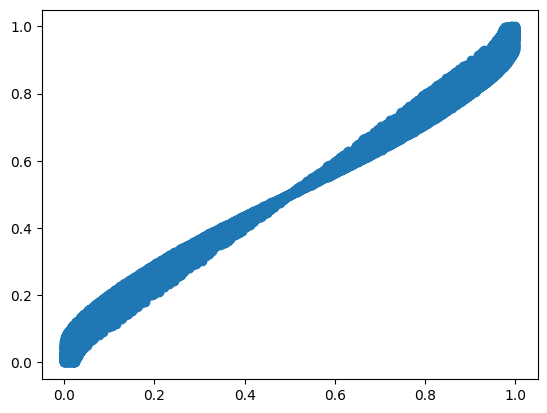

In [61]:
import torch
import numpy as np 
from util import random_cylinder, monte_carlo_volume_ratio
import matplotlib.pyplot as plt
from tqdm import tqdm

def sample_normals(num_samples, device='cuda'):
	"""
	Sample random unit vectors uniformly distributed on the upper hemisphere.
	
	Args:
		num_samples (int): Number of unit vectors to sample.
		device (str): Device to perform the computation ('cpu' or 'cuda').
		
	Returns:
		torch.Tensor: Tensor of shape (num_samples, 3) containing the sampled unit vectors.
	"""
	phi = torch.rand(num_samples, device=device) * 2 * torch.pi
	theta = torch.acos(torch.rand(num_samples, device=device))

	x = torch.sin(theta) * torch.cos(phi)
	y = torch.sin(theta) * torch.sin(phi)
	z = torch.cos(theta)

	return torch.stack((x, y, z), dim=1)


normals = sample_normals(10000).cpu().numpy()

height = 2.3 
radius = 1.0

gt, approx = [], []
for normal in tqdm(normals):
	shift = (np.random.rand(1) - 0.5)[0]
	origin = np.array([0., 0., shift*height])
	x1 = origin + normal*height/2
	x2 = origin - normal*height/2 

	a,b,c,d = 0,0,1,0 # ax + by + cz +d = 0 
	burial_frac_gt = 1 - monte_carlo_volume_ratio(100000, x1, x2, radius, a,b,c,d)
	burial_frac_approx = np.clip(0.5 - shift,0,1)
	gt.append(burial_frac_gt)
	approx.append(burial_frac_approx)



plt.scatter(gt, approx)

Text(0, 0.5, 'Approximation with 0.5 - shift')

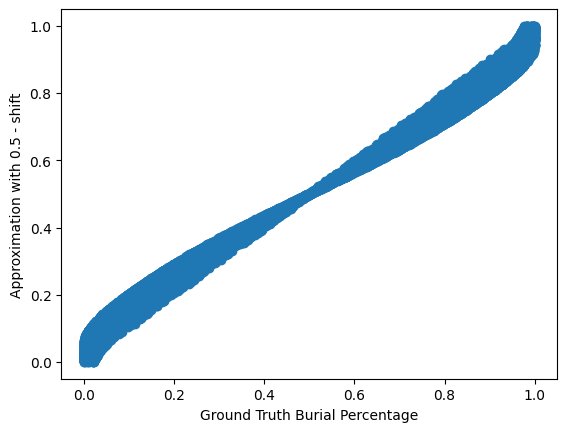

In [62]:
plt.scatter(gt, approx)
plt.xlabel('Ground Truth Burial Percentage')
plt.ylabel('Approximation with 0.5 - shift')